# Market Basket Analysis with Apriori
Using the Online Retail dataset, we will:
- Preprocess the dataset
- Create transaction baskets
- Apply the Apriori algorithm
- Generate and analyze association rules
- Visualize item supports and key rules

In [2]:

import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict


In [3]:

# Load dataset (update the path if needed)
DATA_PATH = "/content/sample_data/Online retail.xlsx"

df = pd.read_excel(DATA_PATH, sheet_name=0)
print("Shape:", df.shape)
df.head()


Shape: (7500, 1)


,"shrimp,almonds,avocado,vegetables mix,green grapes,whole weat flour,yams,cottage cheese,energy drink,tomato juice,low fat yogurt,green tea,honey,salad,mineral water,salmon,antioxydant juice,frozen smoothie,spinach,olive oil"
0,"burgers,meatballs,eggs"
1,chutney
2,"turkey,avocado"
3,"mineral water,milk,energy bar,whole wheat rice..."
4,low fat yogurt


In [4]:

# The dataset has only one column of transactions (comma-separated items)
col = df.columns[0]
df[col] = df[col].astype(str)

# Convert to list of lists
transactions = df[col].apply(lambda x: [i.strip() for i in x.split(",")]).tolist()
print("Number of transactions:", len(transactions))
print("Example transaction:", transactions[0])


Number of transactions: 7500
Example transaction: ['burgers', 'meatballs', 'eggs']


In [8]:
# Create basket (one-hot encoding)
all_items = sorted(set(i for t in transactions for i in t))  # ensure unique items
basket = pd.DataFrame(0, index=range(len(transactions)), columns=all_items)

for i, t in enumerate(transactions):
    unique_items = list(set(t))  # convert set -> list for indexing
    basket.loc[i, unique_items] = 1

basket.head()


,almonds,antioxydant juice,asparagus,avocado,babies food,bacon,barbecue sauce,black tea,blueberries,body spray,...,turkey,vegetables mix,water spray,white wine,whole weat flour,whole wheat pasta,whole wheat rice,yams,yogurt cake,zucchini
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,1,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [9]:

def apriori(transactions, min_support=0.01):
    num_trans = len(transactions)
    item_counts = defaultdict(int)
    for t in transactions:
        for item in t:
            item_counts[frozenset([item])] += 1

    L = {1: {i: c/num_trans for i,c in item_counts.items() if c/num_trans >= min_support}}
    k = 2
    while True:
        prev_L = list(L[k-1].keys())
        candidates = set([i.union(j) for idx,i in enumerate(prev_L) for j in prev_L[idx+1:] if len(i.union(j))==k])
        item_counts = defaultdict(int)
        for t in transactions:
            tset = set(t)
            for cand in candidates:
                if cand.issubset(tset):
                    item_counts[cand] += 1
        Lk = {i:c/num_trans for i,c in item_counts.items() if c/num_trans >= min_support}
        if not Lk: break
        L[k] = Lk
        k+=1
    return L

# Run apriori
frequent_itemsets = apriori(transactions, min_support=0.01)
print("Levels found:", [len(frequent_itemsets[k]) for k in frequent_itemsets])


Levels found: [75, 167, 17]


In [10]:

def generate_rules(frequent_itemsets, min_conf=0.3, min_lift=1.2, num_trans=None):
    if num_trans is None:
        num_trans = len(transactions)
    supports = {}
    for k,v in frequent_itemsets.items():
        for i,s in v.items():
            supports[i] = s

    rules = []
    for itemset, support in supports.items():
        if len(itemset) < 2: continue
        for item in itemset:
            antecedent = frozenset([item])
            consequent = itemset - antecedent
            conf = support / supports[antecedent]
            lift = conf / supports[consequent]
            if conf >= min_conf and lift >= min_lift:
                rules.append({
                    "antecedents": tuple(antecedent),
                    "consequents": tuple(consequent),
                    "support": support,
                    "confidence": conf,
                    "lift": lift
                })
    return pd.DataFrame(rules)

rules = generate_rules(frequent_itemsets, min_conf=0.3, min_lift=1.2)
rules.sort_values("lift", ascending=False).head()


,antecedents,consequents,support,confidence,lift
27,"(herb & pepper,)","(ground beef,)",0.016000,0.323450,3.291555
13,"(soup,)","(milk,)",0.015200,0.300792,2.320923
14,"(ground beef,)","(spaghetti,)",0.039200,0.398915,2.290857
36,"(red wine,)","(spaghetti,)",0.010267,0.364929,2.095687
25,"(olive oil,)","(spaghetti,)",0.022933,0.348884,2.003547


In [11]:

rules.to_csv("association_rules.csv", index=False)
print("Rules saved to association_rules.csv")


Rules saved to association_rules.csv


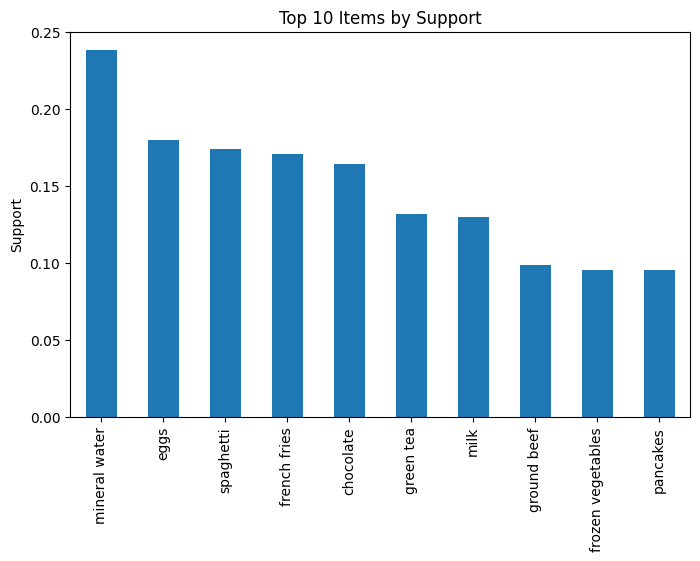

In [12]:

item_support = pd.Series({list(k)[0]: v for k,v in frequent_itemsets[1].items()}).sort_values(ascending=False)
top_items = item_support.head(10)

plt.figure(figsize=(8,5))
top_items.plot(kind='bar')
plt.title("Top 10 Items by Support")
plt.ylabel("Support")
plt.show()
